first I import the necessary libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

then I imported the file containing the training data

In [5]:
df = pd.read_csv('C:/Users/aarus/Downloads/Train.csv')

Then I made a user defined function to process the data according to my needs

In [6]:
def preprocess_data(df):
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce').astype(int)
    df['Kilometers_Driven'] = df['Kilometers_Driven'].replace({' km': '', ',': ''}, regex=True).astype(float)
    def extract_brand_model(name):
        if pd.isna(name):
            return None, None
        parts = name.split(' ')
        brand = parts[0]
        model = ' '.join(parts[1:]) if len(parts) > 1 else None
        return brand, model
    df[['Brand', 'Model']] = df['Name'].apply(lambda x: pd.Series(extract_brand_model(x)))
    owner_type_categories = df['Owner_Type'].astype('category')
    df['Owner_Type_Code'] = owner_type_categories.cat.codes
    df['Owner_Type'] = owner_type_categories.cat.categories[owner_type_categories.cat.codes].values
    brand_categories = df['Brand'].astype('category')
    df['Brand_Code'] = brand_categories.cat.codes
    df['Brand'] = brand_categories.cat.categories[brand_categories.cat.codes].values
    model_categories = df['Model'].astype('category')
    df['Model_Code'] = model_categories.cat.codes
    df['Model'] = model_categories.cat.categories[model_categories.cat.codes].values
    df['Mileage'] = pd.to_numeric(df['Mileage'].str.replace(' kmpl', '').replace(' N/A', np.nan), errors='coerce')
    df['Engine'] = pd.to_numeric(df['Engine'].str.replace(' CC', '').replace(' N/A', np.nan), errors='coerce')
    df['Power'] = pd.to_numeric(df['Power'].str.replace(' bhp', '').replace(' N/A', np.nan), errors='coerce')
    df['Seats'] = pd.to_numeric(df['Seats'], errors='coerce').fillna(df['Seats'].mean()).astype(int)
    fuel_type_categories = df['Fuel_Type'].astype('category')
    df['Fuel_Type_Code'] = fuel_type_categories.cat.codes
    df['Fuel_Type'] = fuel_type_categories.cat.categories[fuel_type_categories.cat.codes].values
    transmission_categories = df['Transmission'].astype('category')
    df['Transmission_Code'] = transmission_categories.cat.codes
    df['Transmission'] = transmission_categories.cat.categories[transmission_categories.cat.codes].values
    location_categories = df['Location'].astype('category')
    df['Location_Code'] = location_categories.cat.codes
    df['Location'] = location_categories.cat.categories[location_categories.cat.codes].values
    for col in ['Mileage', 'Engine', 'Power']:
        df[col] = df[col].fillna(df[col].mean())
    return df

df = preprocess_data(df)


I then removed the outliersin the data using a user defined method to get a better variance accuracy

In [7]:
def remove_outliers(df):
    for col in ['Year', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Price']:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df
if 'Price' in df.columns:
    df = remove_outliers(df)
else:
    raise ValueError("Price column is missing from the DataFrame.")

Then I defined the features and the target variable 

In [8]:
feature_columns = ['Year', 'Kilometers_Driven', 'Owner_Type_Code', 'Mileage', 'Engine', 'Power', 'Seats', 'Fuel_Type_Code', 'Transmission_Code', 'Location_Code','Brand_Code','Model_Code']
target_column = 'Price'

I then defined the features and target variable of the data

In [9]:
X = df[feature_columns].to_numpy()
y = df[target_column].to_numpy()

I then normalised the matrix x by rescaling its values

In [10]:
X_min = X.min(axis=0)
X_max = X.max(axis=0)
X = (X - X_min) / (X_max - X_min)

Then I moved onto the actual Linreg model

In [11]:
def LinReg_with_gradient_descent(X, y, alpha, epochs):
    m = X.shape[0]
    ones = np.ones((m, 1))  
    X = np.concatenate((ones, X), axis=1)
    n = X.shape[1]  
    Theta = np.zeros(n)  
    cost = np.zeros(epochs)  
    for i in range(epochs):
        h = np.dot(X, Theta)
        error = h - y  
        update = (alpha / m) * np.dot(X.T, error)
        Theta -= update  
        if i % 10000 == 0: 
            print(f"Progress: {i * 100 / epochs:.2f}%")
        cost[i] = (1 / (2 * m)) * np.sum(np.square(error))
        if np.isnan(cost[i]) or np.isnan(Theta).any():
            print("NaN encountered during training!")
            break
    return cost, Theta

Then I specified the value of alpha and epoch and stored output from algorithm in the variables

In [12]:
alpha = 0.0999  # Reduced learning rate
epochs = 10000
cost, Theta = LinReg_with_gradient_descent(X, y, alpha, epochs)

Progress: 0.00%


I then add a column of one to feature matrix then stored the predictions in a variable

In [13]:
X_with_intercept = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
y_pred_best = np.dot(X_with_intercept, Theta)

I then calculated the metrics for the model

In [14]:
mae = np.mean(np.abs(y - y_pred_best))
mse = np.mean((y - y_pred_best) ** 2)
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
def r_squared(y_true, y_pred):
    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    return 1 - (ss_residual / ss_total) if ss_total != 0 else 0
r2 = r_squared(y, y_pred_best)
print("R-squared:", r2)

Mean Absolute Error: 1.3022263249144372
Mean Squared Error: 3.077502122414365
R-squared: 0.7360647995238022


I then plotted the best fit line against the data

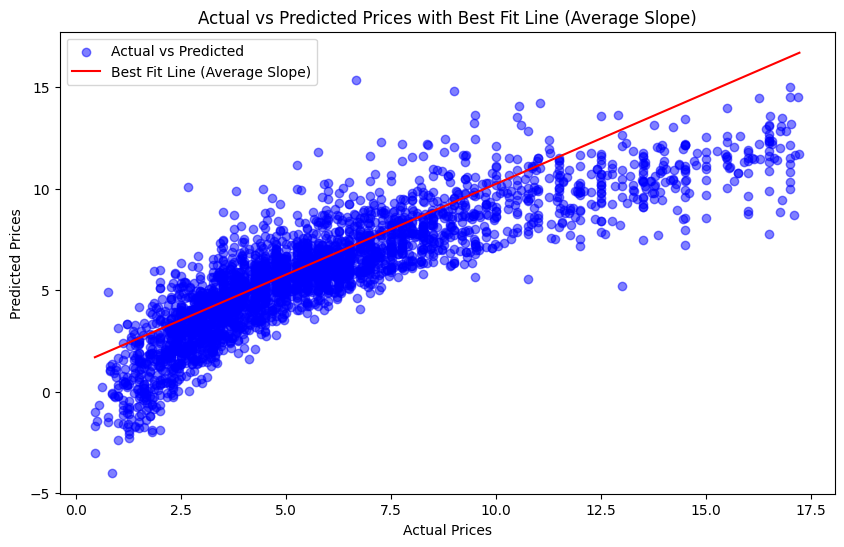

In [15]:
slopes = []
for i in range(1, len(y)):
    x1, y1 = y[i-1], y_pred_best[i-1]  
    x2, y2 = y[i], y_pred_best[i]      
    if x2 != x1: 
        slope = (y2 - y1) / (x2 - x1)
        slopes.append(slope)
avg_slope = np.mean(slopes)
intercept = y_pred_best[0] - avg_slope * y[0]
line_x = np.linspace(min(y), max(y), 100)
line_y = avg_slope * line_x + intercept  
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred_best, color='b', label="Actual vs Predicted", alpha=0.5)
plt.plot(line_x, line_y, color='r', label="Best Fit Line (Average Slope)")
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices with Best Fit Line (Average Slope)")
plt.legend()
plt.show()

Then I loaded and pre-porcessed the new data

In [16]:
new_data_df = pd.read_csv('C:/Users/aarus/Downloads/Test.csv')
new_data_df = preprocess_data(new_data_df)

Then I used a similar process as with the earlier file to prepare the input for prediction 

In [17]:
X_new = new_data_df[feature_columns].to_numpy()
X_new = (X_new - X_min) / (X_max - X_min)
X_new_with_intercept = np.concatenate((np.ones((X_new.shape[0], 1)), X_new), axis=1)

Then I made the predictions and stored them along with the accuracy

In [18]:
predicted_prices = np.dot(X_new_with_intercept, Theta)
predicted_prices = np.clip(predicted_prices, a_min=mae, a_max=None)
new_data_df['Predicted_Price'] = predicted_prices
actual_prices = new_data_df['Price'].to_numpy()
output_df = new_data_df[['Name', 'Location', 'Year', 'Kilometers_Driven', 
                          'Fuel_Type', 'Transmission', 'Owner_Type', 
                          'Mileage', 'Engine', 'Power', 'Seats', 
                          'Price', 'Predicted_Price']]
output_df['Accuracy'] = (predicted_prices * 100 / actual_prices).round(2).astype(str)
output_df.to_csv('C:/Users/aarus/Downloads/random.csv', index=False)
print(output_df)

                               Name    Location  Year  Kilometers_Driven  \
0            Maruti Swift Dzire VDI   Hyderabad  2013            84175.0   
1             Hyundai i10 Sportz AT       Delhi  2012            62282.0   
2     Hyundai Elite i20 Sportz Plus       Kochi  2017            37460.0   
3                     Volvo XC60 D5        Pune  2011           106976.0   
4             Hyundai i10 Magna 1.2       Delhi  2013            60000.0   
...                             ...         ...   ...                ...   
1245     Hyundai Elantra CRDi SX AT       Delhi  2013            71000.0   
1246           Hyundai Getz GLS ABS        Pune  2005            91000.0   
1247         Volkswagen Polo GT TSI  Coimbatore  2017            50534.0   
1248       Hyundai Verna SX CRDi AT        Pune  2012            83000.0   
1249        Maruti Baleno Alpha CVT       Kochi  2019            13574.0   

     Fuel_Type Transmission Owner_Type  Mileage  Engine   Power  Seats  Price  \
0     

C:\Users\aarus\AppData\Local\Temp\ipykernel_5804\640219137.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_df['Accuracy'] = (predicted_prices * 100 / actual_prices).round(2).astype(str)


Then I calculated the Mean Absolute percentage error and plotted it with the number of cars in the data set

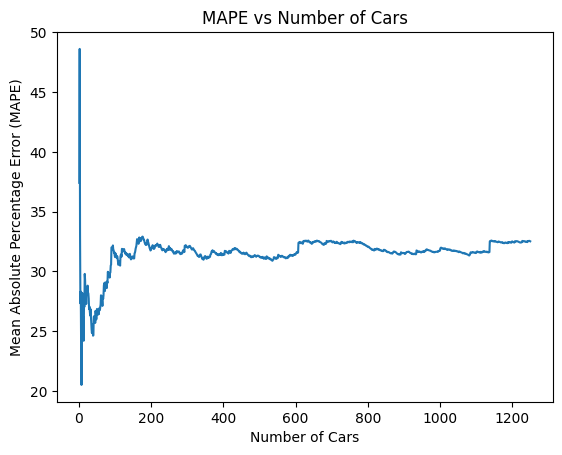

In [19]:
accuracies = []
car_counts = []
for i in range(1, len(new_data_df) + 1):
    current_actual = actual_prices[:i]
    current_predicted = predicted_prices[:i]
    mape = np.mean(np.abs((current_actual - current_predicted) / current_actual)) * 100
    accuracies.append(mape)
    car_counts.append(i)
plt.plot(car_counts, accuracies)
plt.xlabel("Number of Cars")
plt.ylabel("Mean Absolute Percentage Error (MAPE)")
plt.title("MAPE vs Number of Cars")
plt.show()

I also added a loss vs epochs graph

Progress: 0.00%
Progress: 0.00%
Progress: 0.00%
Progress: 0.00%
Progress: 0.00%
Progress: 0.00%
Progress: 10.00%
Progress: 20.00%
Progress: 30.00%
Progress: 40.00%
Progress: 50.00%
Progress: 60.00%
Progress: 70.00%
Progress: 80.00%
Progress: 90.00%
Progress: 0.00%
Progress: 1.00%
Progress: 2.00%
Progress: 3.00%
Progress: 4.00%
Progress: 5.00%
Progress: 6.00%
Progress: 7.00%
Progress: 8.00%
Progress: 9.00%
Progress: 10.00%
Progress: 11.00%
Progress: 12.00%
Progress: 13.00%
Progress: 14.00%
Progress: 15.00%
Progress: 16.00%
Progress: 17.00%
Progress: 18.00%
Progress: 19.00%
Progress: 20.00%
Progress: 21.00%
Progress: 22.00%
Progress: 23.00%
Progress: 24.00%
Progress: 25.00%
Progress: 26.00%
Progress: 27.00%
Progress: 28.00%
Progress: 29.00%
Progress: 30.00%
Progress: 31.00%
Progress: 32.00%
Progress: 33.00%
Progress: 34.00%
Progress: 35.00%
Progress: 36.00%
Progress: 37.00%
Progress: 38.00%
Progress: 39.00%
Progress: 40.00%
Progress: 41.00%
Progress: 42.00%
Progress: 43.00%
Progress: 44.

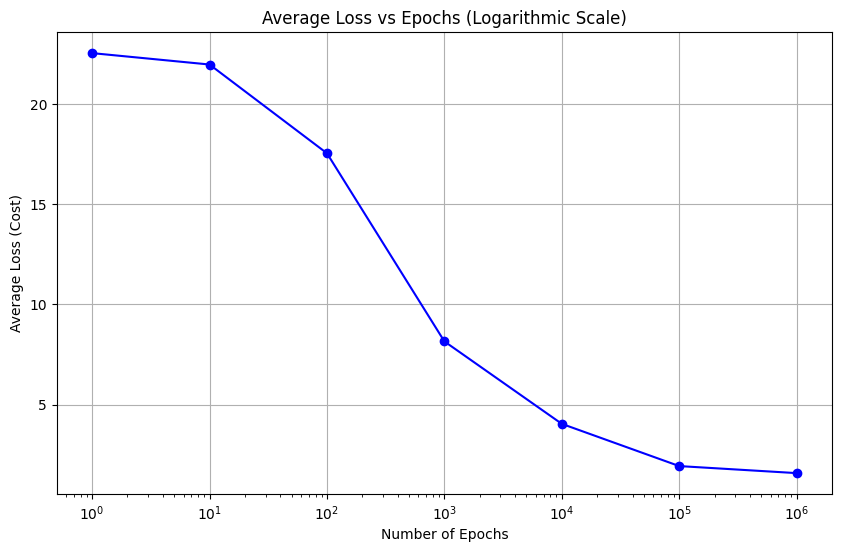

In [20]:
def test_epochs(X, y, alpha, epoch_range):
    avg_losses = [] 
    qwerty=1
    for power in epoch_range:
       
        epochs = 10**power
        cost,qwerty = LinReg_with_gradient_descent(X, y, alpha, epochs)
        avg_losses.append(np.mean(cost))  

    return avg_losses

epoch_range = np.arange(0, 7) 
alpha = 0.001 
avg_losses = test_epochs(X, y, alpha, epoch_range)
plt.figure(figsize=(10, 6))
plt.plot(10**epoch_range, avg_losses, marker='o', color='b')
plt.xscale('log') 
plt.xlabel('Number of Epochs')
plt.ylabel('Average Loss (Cost)')
plt.title('Average Loss vs Epochs (Logarithmic Scale)')
plt.grid(True)
plt.show()

I also added a function to show the variation of mae, mse, r2 and average loss with epochs

Progress: 0.00%
Progress: 0.00%
Progress: 0.00%
Progress: 0.00%
Progress: 0.00%
Progress: 0.00%
Progress: 10.00%
Progress: 20.00%
Progress: 30.00%
Progress: 40.00%
Progress: 50.00%
Progress: 60.00%
Progress: 70.00%
Progress: 80.00%
Progress: 90.00%
Progress: 0.00%
Progress: 1.00%
Progress: 2.00%
Progress: 3.00%
Progress: 4.00%
Progress: 5.00%
Progress: 6.00%
Progress: 7.00%
Progress: 8.00%
Progress: 9.00%
Progress: 10.00%
Progress: 11.00%
Progress: 12.00%
Progress: 13.00%
Progress: 14.00%
Progress: 15.00%
Progress: 16.00%
Progress: 17.00%
Progress: 18.00%
Progress: 19.00%
Progress: 20.00%
Progress: 21.00%
Progress: 22.00%
Progress: 23.00%
Progress: 24.00%
Progress: 25.00%
Progress: 26.00%
Progress: 27.00%
Progress: 28.00%
Progress: 29.00%
Progress: 30.00%
Progress: 31.00%
Progress: 32.00%
Progress: 33.00%
Progress: 34.00%
Progress: 35.00%
Progress: 36.00%
Progress: 37.00%
Progress: 38.00%
Progress: 39.00%
Progress: 40.00%
Progress: 41.00%
Progress: 42.00%
Progress: 43.00%
Progress: 44.

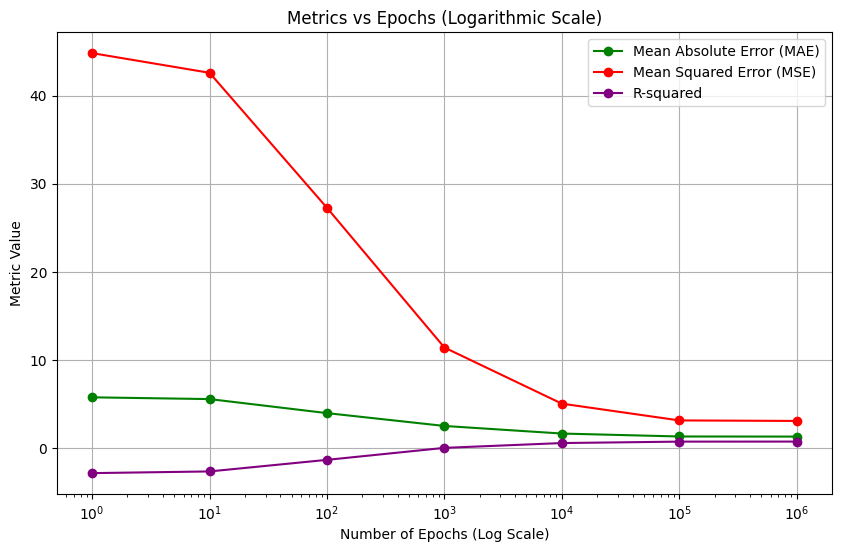

In [21]:
def calculate_metrics(y_true, y_pred):
    mae = np.mean(np.abs(y_true - y_pred)) 
    mse = np.mean((y_true - y_pred) ** 2) 
    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_residual / ss_total) if ss_total != 0 else 0  
    return mae, mse, r2
def test_epochs(X, y, alpha, epoch_range):
    avg_losses = [] 
    maes = [] 
    mses = []  
    r2s = []  

    for power in epoch_range:
        epochs = 10**power
        cost, Theta = LinReg_with_gradient_descent(X, y, alpha, epochs)
        X_with_intercept = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1) 
        y_pred = np.dot(X_with_intercept, Theta)
        mae, mse, r2 = calculate_metrics(y, y_pred)       
        avg_losses.append(np.mean(cost))  
        maes.append(mae)
        mses.append(mse)
        r2s.append(r2)

    return avg_losses, maes, mses, r2s
epoch_range = np.arange(0, 7)  
alpha = 0.001  
avg_losses, maes, mses, r2s = test_epochs(X, y, alpha, epoch_range)
plt.figure(figsize=(10, 6))
#plt.plot(10**epoch_range, avg_losses, marker='o', color='b', label='Average Loss (Cost)')
plt.plot(10**epoch_range, maes, marker='o', color='g', label='Mean Absolute Error (MAE)')
plt.plot(10**epoch_range, mses, marker='o', color='r', label='Mean Squared Error (MSE)')
plt.plot(10**epoch_range, r2s, marker='o', color='purple', label='R-squared')
plt.xscale('log')
plt.xlabel('Number of Epochs (Log Scale)')
plt.ylabel('Metric Value')
plt.title('Metrics vs Epochs (Logarithmic Scale)')
plt.legend()
plt.grid(True)
plt.show()

I made a similar combined function for alpha values

Progress: 0.00%
Progress: 0.00%
Progress: 0.00%
Progress: 0.00%
Progress: 0.00%
Progress: 0.00%
Progress: 0.00%
Progress: 0.00%
Progress: 0.00%
Progress: 0.00%
Progress: 0.00%
Progress: 0.00%
Progress: 0.00%
Progress: 0.00%
Progress: 0.00%
Progress: 0.00%
Progress: 0.00%
Progress: 0.00%
Progress: 0.00%
Progress: 0.00%


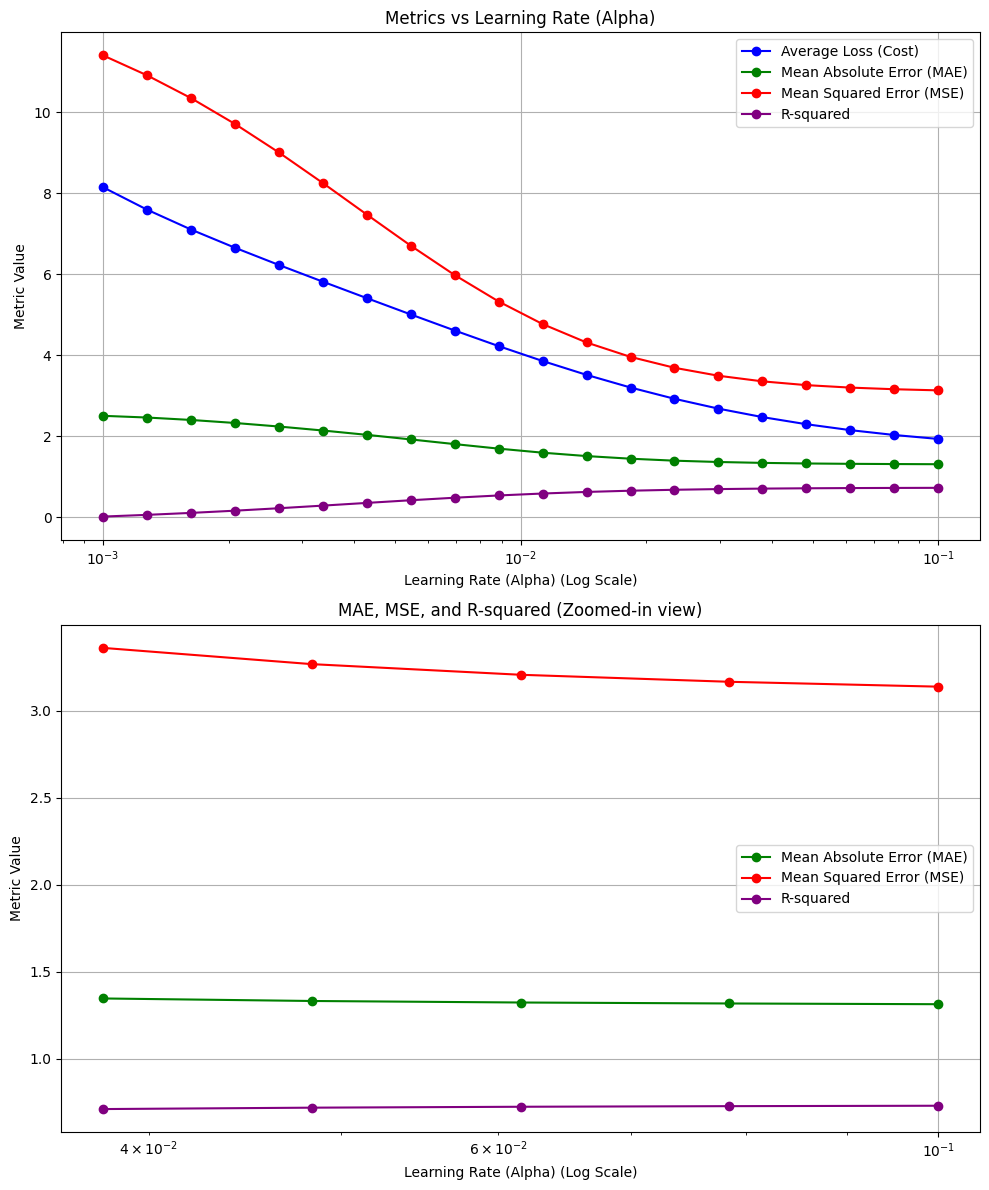

In [ ]:
def test_alphas(X, y, alpha_range, epochs=1000):
    avg_losses = [] 
    maes = [] 
    mses = [] 
    r2s = []  

    for alpha in alpha_range:
        cost, Theta = LinReg_with_gradient_descent(X, y, alpha, epochs)
        X_with_intercept = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
        y_pred = np.dot(X_with_intercept, Theta)
        mae, mse, r2 = calculate_metrics(y, y_pred)
        avg_losses.append(np.mean(cost)) 
        maes.append(mae)
        mses.append(mse)
        r2s.append(r2)

    return avg_losses, maes, mses, r2s

alpha_range = np.logspace(-3, -1, 20) 
avg_losses, maes, mses, r2s = test_alphas(X, y, alpha_range)
fig, axes = plt.subplots(2, 1, figsize=(10, 12))
axes[0].plot(alpha_range, avg_losses, marker='o', color='b', label='Average Loss (Cost)')
axes[0].plot(alpha_range, maes, marker='o', color='g', label='Mean Absolute Error (MAE)')
axes[0].plot(alpha_range, mses, marker='o', color='r', label='Mean Squared Error (MSE)')
axes[0].plot(alpha_range, r2s, marker='o', color='purple', label='R-squared')
axes[0].set_xscale('log')
axes[0].set_xlabel('Learning Rate (Alpha) (Log Scale)')
axes[0].set_ylabel('Metric Value')
axes[0].set_title('Metrics vs Learning Rate (Alpha)')
axes[0].legend()
axes[0].grid(True)
zoom_idx = -5  
axes[1].plot(alpha_range[zoom_idx:], maes[zoom_idx:], marker='o', color='g', label='Mean Absolute Error (MAE)')
axes[1].plot(alpha_range[zoom_idx:], mses[zoom_idx:], marker='o', color='r', label='Mean Squared Error (MSE)')
axes[1].plot(alpha_range[zoom_idx:], r2s[zoom_idx:], marker='o', color='purple', label='R-squared')
axes[1].set_xscale('log')
axes[1].set_xlabel('Learning Rate (Alpha) (Log Scale)')
axes[1].set_ylabel('Metric Value')
axes[1].set_title('MAE, MSE, and R-squared (Zoomed-in view)')
axes[1].legend()
axes[1].grid(True)
plt.tight_layout()
plt.show()